# **Data Description**

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [96]:
dataset = pd.read_csv('../broward_data.csv')   # working dataset

### IDENTIFY FEATURES AND TARGETS ###
features = ['person_id','screening_date','sex','race','age_at_current_charge',
            'age_at_first_charge','p_charges','p_incarceration','p_probation',
            'p_juv_fel_count','p_felprop_viol','p_murder','p_felassault',
            'p_misdeassault','p_famviol','p_sex_offense','p_weapon','p_fta_two_year',
            'p_fta_two_year_plus','current_violence','current_violence20',
            'p_pending_charge','p_felony','p_misdemeanor','p_violence',
            'total_convictions','p_arrest','p_property','p_traffic','p_drug','p_dui',
            'p_domestic','p_stalking','p_voyeurism','p_fraud','p_stealing','p_trespass',
            'six_month','one_year','three_year','five_year']
targets = ['general_two_year','general_six_month','drug_two_year','property_two_year',
           'misdemeanor_two_year','felony_two_year','violent_two_year','drug_six_month', 
           'property_six_month','misdemeanor_six_month','felony_six_month',
           'violent_six_month']



## **Feature engineering**

In [97]:
### ADD FEATURES ###

#make years_since_first_charge
dataset['years_since_first_charge'] = dataset['age_at_current_charge'] - dataset['age_at_first_charge']
features.append('years_since_first_charge')

#make count of types of charges a person has
charge_types = ['p_felprop_viol', 'p_murder', 'p_felassault','p_misdeassault', 
                'p_famviol', 'p_sex_offense', 'p_weapon', 'p_violence', 'p_property', 
                'p_traffic', 'p_drug', 'p_dui','p_domestic', 'p_stalking', 
                'p_voyeurism', 'p_fraud', 'p_stealing', 'p_trespass']
dataset['charge_types'] = dataset[charge_types].apply(lambda x: (x > 0).sum(), axis=1)
features.append('charge_types')

#make rate of new charges
dataset['charge_rate']=dataset['p_charges']/(dataset['years_since_first_charge']+1)
features.append('charge_rate')

#make convictions per charge
dataset['conviction_rate']=dataset['total_convictions']/dataset['p_charges']
features.append('conviction_rate')

#make incarcerations per charge
dataset['incarceration_rate']=dataset['p_incarceration']/dataset['p_charges']
features.append('incarceration_rate')


In [98]:
###ELIMINATE FEATURES###

# person id is randomly assigned
dataset = dataset.drop('person_id', axis=1)
features.remove('person_id')

# screening date is not relevant
dataset = dataset.drop('screening_date', axis=1)
features.remove('screening_date')

# don't consider race
dataset = dataset.drop('race', axis=1)
features.remove('race')

**Check data for any glaring issues**

In [99]:
### MISSING DATA ###
missing_vals = dataset.isna().sum().sum()           #num missing values
total_vals = np.product(dataset.shape)              #total num values
pct_missing = (missing_vals / total_vals) * 100     #percent of the data missing
print(f'Percentage of the data missing: {pct_missing}%\n')

### INCORRECT DATA TYPES ###
#make sure theyre all int64 or float64
data_types = dataset.dtypes
print(data_types)

Percentage of the data missing: 0.0%

sex                           int64
age_at_current_charge         int64
age_at_first_charge           int64
p_charges                     int64
p_incarceration               int64
p_probation                   int64
p_juv_fel_count               int64
p_felprop_viol                int64
p_murder                      int64
p_felassault                  int64
p_misdeassault                int64
p_famviol                     int64
p_sex_offense                 int64
p_weapon                      int64
p_fta_two_year                int64
p_fta_two_year_plus           int64
current_violence              int64
current_violence20            int64
p_pending_charge              int64
p_felony                      int64
p_misdemeanor                 int64
p_violence                    int64
total_convictions             int64
p_arrest                      int64
p_property                    int64
p_traffic                     int64
p_drug                    

#### **Preliminary Analysis**

##### Histograms

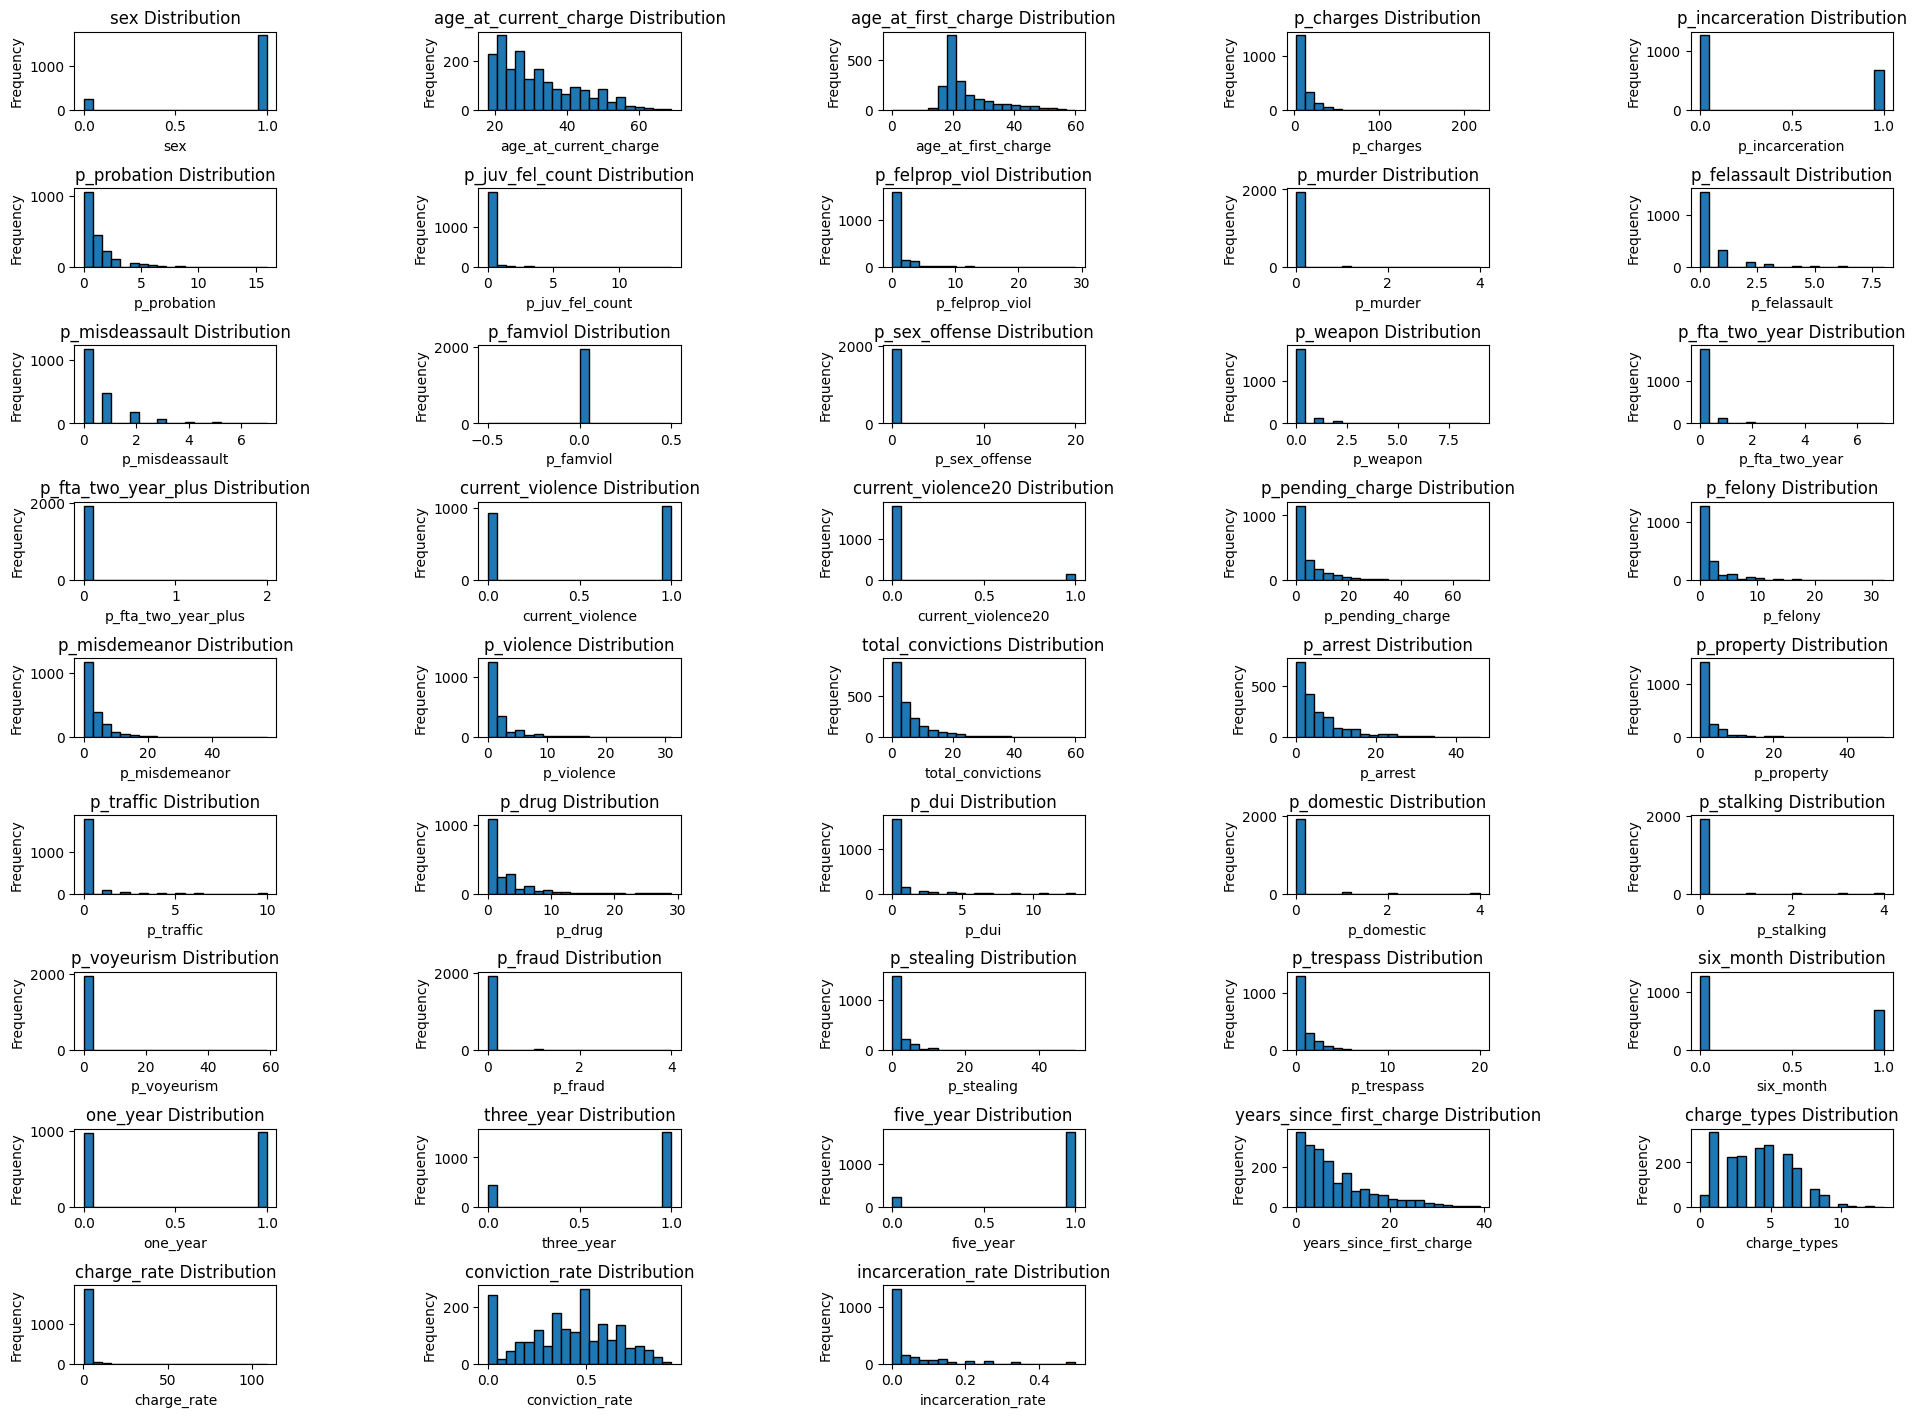

In [100]:
### HISTOGRAMS ###
# to show distribution of data

cols=5
rows = (len(features)+cols-1)//cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
fig.tight_layout(pad=5.0)

for i, feature in enumerate(features):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.hist(dataset[feature], bins=20, edgecolor='black')
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

for n in range(i+1, rows*cols):
    fig.delaxes(axes.flatten()[n])

# display
plt.subplots_adjust(hspace=1, wspace=1)
plt.show()

In [101]:
# it appears that the variance of feature 'p_famviol' is zero. confirm this:
if dataset['p_famviol'].max() == dataset['p_famviol'].min():
    print(True)
else: 
    print(False)


True


In [102]:
# remove famviol feature
dataset = dataset.drop('p_famviol', axis=1)
features.remove('p_famviol')

In [103]:
# it also looks like theres one person who was first charged at age 0:

if((dataset['age_at_first_charge'] == 0).any()):
    print((dataset['age_at_first_charge'] == 0).sum())
else:
    print(False)


1


In [104]:
# remove person who was charged at age 0
dataset = dataset[dataset['age_at_first_charge'] != 0]

##### Scatter plots

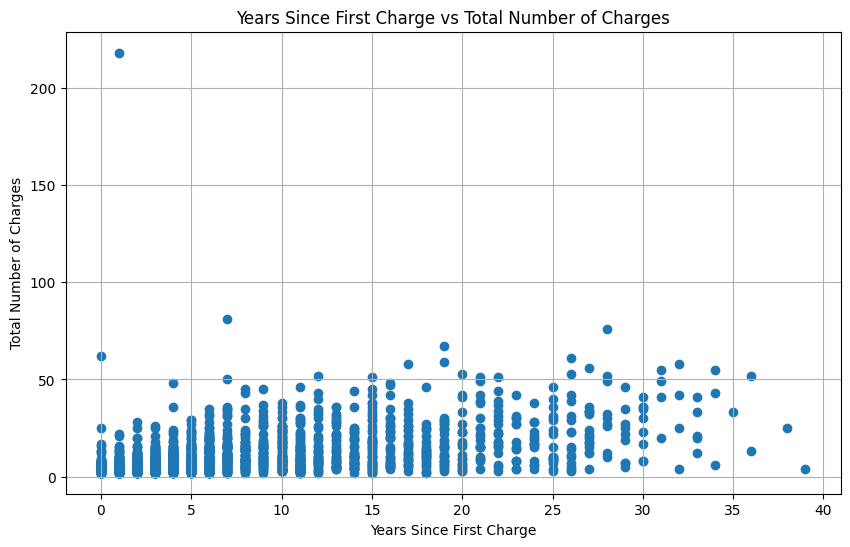

In [105]:
### SCATTER PLOTS ###
# to show relationships between features/targets

# years since first charge vs number of past charges
plt.figure(figsize=(10, 6))
plt.scatter(dataset['years_since_first_charge'], dataset['p_charges'])
plt.title('Years Since First Charge vs Total Number of Charges')
plt.xlabel('Years Since First Charge')
plt.ylabel('Total Number of Charges')
plt.grid(True)
plt.show()

In [106]:
# get rid of that outlier datapoint
dataset = dataset[dataset['p_charges'] < 200]

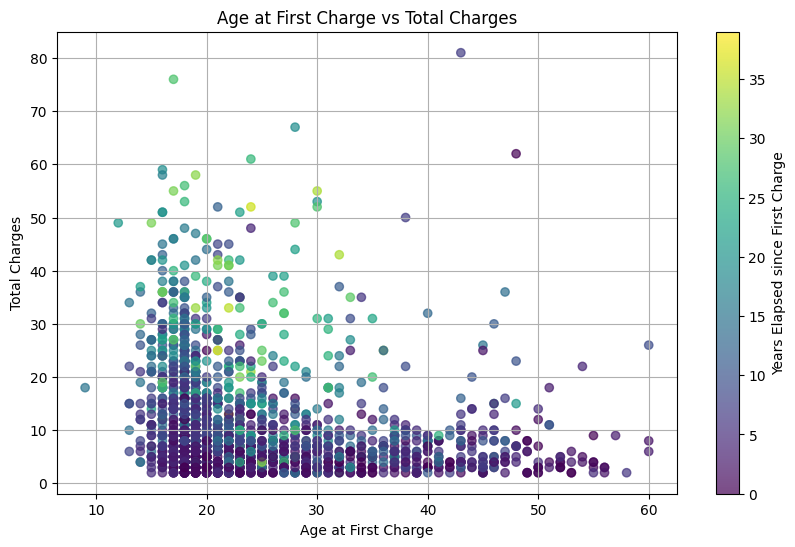

In [107]:
# age at first charge vs previous charges, with color scale for years since first charge
plt.figure(figsize=(10, 6))
scatter = plt.scatter(dataset['age_at_first_charge'], dataset['p_charges'], c=dataset['years_since_first_charge'], alpha=0.7)
plt.title('Age at First Charge vs Total Charges')
plt.xlabel('Age at First Charge')
plt.ylabel('Total Charges')
plt.grid(True)
cbar = plt.colorbar(scatter, label='Years Elapsed since First Charge')
plt.show()


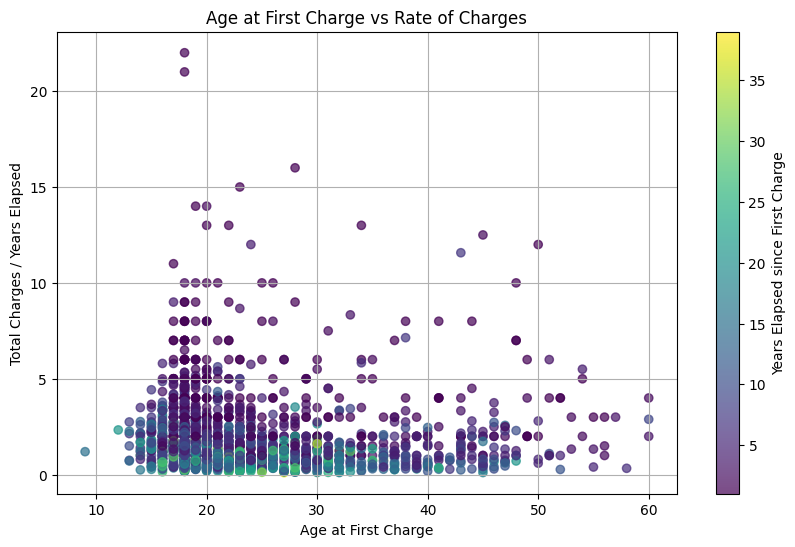

In [108]:
# age at first charge vs rate of charges
plt.figure(figsize=(10, 6))
scatter = plt.scatter(dataset['age_at_first_charge'], dataset['p_charges']/dataset['years_since_first_charge'], c=dataset['years_since_first_charge'], alpha=0.7)
plt.title('Age at First Charge vs Rate of Charges')
plt.xlabel('Age at First Charge')
plt.ylabel('Total Charges / Years Elapsed')
plt.grid(True)
cbar = plt.colorbar(scatter, label='Years Elapsed since First Charge')
plt.show()

**Check for imbalance**

general_two_year
0    1064
1     888
Name: count, dtype: int64
general_two_year
0    0.545082
1    0.454918
Name: count, dtype: float64


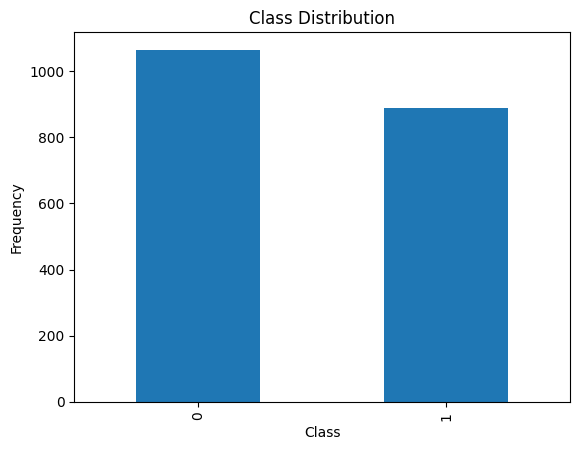

In [109]:
class_counts = dataset['general_two_year'].value_counts()
print(class_counts)

# Proportions
print(class_counts / len(dataset))

# Visual Inspection
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

## **Feature importance**

current_violence
p_traffic
years_since_first_charge


C:\Users\lnick\AppData\Local\Temp\ipykernel_30464\1312368959.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(sorted_features, rotation=90)
C:\Users\lnick\AppData\Local\Temp\ipykernel_30464\1312368959.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(sorted_features, rotation=90)


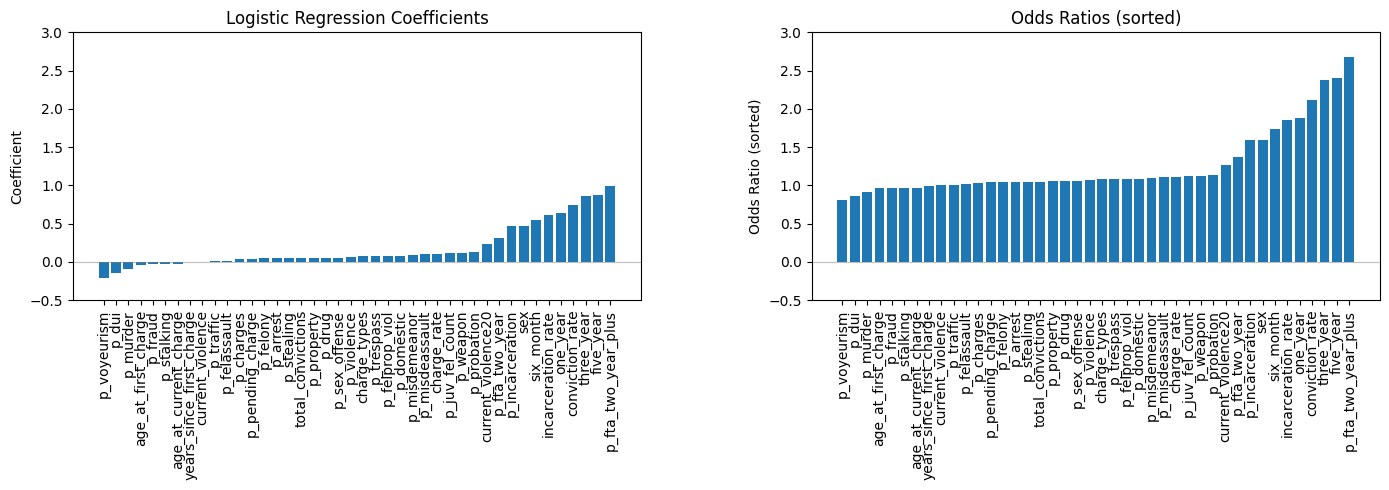

In [110]:
#logistic regression

model = LogisticRegression()
coefs = []
odds_ratios =[]

for feature in features:

    model.fit(dataset[[feature]], dataset['general_two_year'])
    coef = model.coef_[0][0]
    coefs.append(coef)

    if abs(coef)<0.01:
        print(feature)
   

odds_ratios = np.exp(coefs)

sorted_indices = np.argsort(odds_ratios)

sorted_features = [features[i] for i in sorted_indices]
sorted_coefs = [coefs[i] for i in sorted_indices]
sorted_ratios = [odds_ratios[i] for i in sorted_indices]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot coefficients
ax[0].bar(sorted_features, sorted_coefs)
ax[0].set_title('Logistic Regression Coefficients')
ax[0].set_xticklabels(sorted_features, rotation=90)
ax[0].set_ylabel('Coefficient')
ax[0].set_ylim(-0.5,3)

# Plot odds ratios
ax[1].bar(sorted_features, sorted_ratios)
ax[1].set_title('Odds Ratios (sorted)')
ax[1].set_xticklabels(sorted_features, rotation=90)
ax[1].set_ylabel('Odds Ratio (sorted)')
ax[1].set_ylim(-0.5,3)

ax[0].axhline(0, color='gray', linewidth=0.8, alpha=0.5)
ax[1].axhline(0, color='gray', linewidth=0.8, alpha=0.5)
# Show the plots
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()




In [111]:
#examine multicollinearity

X = dataset.assign(const=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

c:\Users\lnick\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                     feature         VIF
0                        sex    1.054615
1      age_at_current_charge         inf
2        age_at_first_charge         inf
3                  p_charges   25.652350
4            p_incarceration    3.531386
5                p_probation    2.325486
6            p_juv_fel_count    1.208324
7             p_felprop_viol   10.202536
8                   p_murder    1.097617
9               p_felassault    2.893290
10            p_misdeassault    2.919087
11             p_sex_offense    1.112675
12                  p_weapon    1.200577
13            p_fta_two_year    1.131310
14       p_fta_two_year_plus    1.040934
15          current_violence    2.176547
16        current_violence20    1.366249
17          p_pending_charge    8.187606
18                  p_felony  122.524112
19             p_misdemeanor  206.553877
20                p_violence   18.578228
21         total_convictions  484.899517
22                  p_arrest    8.897383
23              

this indicates that age_at_current_charge, age_at_first_charge, and years_since_first_charge (which is derived from the previous two) are highly correlated. see how removing years_since_first_charge impacts this

In [112]:
dataset = dataset.drop('years_since_first_charge', axis=1)
features.remove('years_since_first_charge')

remove one of p_stalking and p_fraud

In [113]:
dataset = dataset.drop('p_stalking', axis=1)
features.remove('p_stalking')

In [114]:
#examine multicollinearity

X = dataset.assign(const=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

if np.isinf(vif_data['VIF']).any():
    print("SOME VALUE STILL INFINITY")

                  feature         VIF
0                     sex    1.054615
1   age_at_current_charge    6.814688
2     age_at_first_charge    5.595090
3               p_charges   25.652350
4         p_incarceration    3.531386
5             p_probation    2.325486
6         p_juv_fel_count    1.208324
7          p_felprop_viol   10.202536
8                p_murder    1.097617
9            p_felassault    2.893290
10         p_misdeassault    2.919087
11          p_sex_offense    1.112675
12               p_weapon    1.200577
13         p_fta_two_year    1.131310
14    p_fta_two_year_plus    1.040934
15       current_violence    2.176547
16     current_violence20    1.366249
17       p_pending_charge    8.187606
18               p_felony  122.524112
19          p_misdemeanor  206.553877
20             p_violence   18.578228
21      total_convictions  484.899517
22               p_arrest    8.897383
23             p_property   68.144289
24              p_traffic    2.380411
25          

In [115]:
# p values
coefs = []
odds_ratios = []
p_values = []

X = sm.add_constant(dataset[features])
y = dataset['general_two_year']

model = sm.Logit(y, X).fit()
coefs = model.params[1:] 
odds_ratios = np.exp(coefs)
p_values = model.pvalues[1:]

#sort the features by odds ratios 
sorted_indices = np.argsort(odds_ratios)
sorted_features = [features[i] for i in sorted_indices]
sorted_coefs = coefs[sorted_indices]
sorted_ratios = odds_ratios[sorted_indices]
sorted_p_values = p_values[sorted_indices]

for i, feature in enumerate(sorted_features):
    #if sorted_p_values[i] <0.05:
    print(f"{feature}: coef = {sorted_coefs[i]:.3f}, odds_ratio = {sorted_ratios[i]:.3f}, p-value = {sorted_p_values[i]:.3g}")




Optimization terminated successfully.
         Current function value: 0.630794
         Iterations 11
p_felony: coef = -0.264, odds_ratio = 0.768, p-value = 0.123
p_voyeurism: coef = -0.251, odds_ratio = 0.778, p-value = 0.844
p_stealing: coef = -0.174, odds_ratio = 0.840, p-value = 0.0214
current_violence20: coef = -0.154, odds_ratio = 0.857, p-value = 0.468
p_misdemeanor: coef = -0.153, odds_ratio = 0.858, p-value = 0.371
p_murder: coef = -0.147, odds_ratio = 0.864, p-value = 0.609
p_felassault: coef = -0.145, odds_ratio = 0.865, p-value = 0.101
p_dui: coef = -0.129, odds_ratio = 0.879, p-value = 0.0268
incarceration_rate: coef = -0.123, odds_ratio = 0.884, p-value = 0.899
p_traffic: coef = -0.105, odds_ratio = 0.900, p-value = 0.42
p_domestic: coef = -0.101, odds_ratio = 0.904, p-value = 0.738
p_trespass: coef = -0.083, odds_ratio = 0.921, p-value = 0.36
charge_types: coef = -0.050, odds_ratio = 0.951, p-value = 0.108
age_at_current_charge: coef = -0.028, odds_ratio = 0.972, p-valu

C:\Users\lnick\AppData\Local\Temp\ipykernel_30464\2498834065.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_coefs = coefs[sorted_indices]
C:\Users\lnick\AppData\Local\Temp\ipykernel_30464\2498834065.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_ratios = odds_ratios[sorted_indices]
C:\Users\lnick\AppData\Local\Temp\ipykernel_30464\2498834065.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_p_valu

## **see distribution of variables, by target general_two_year**

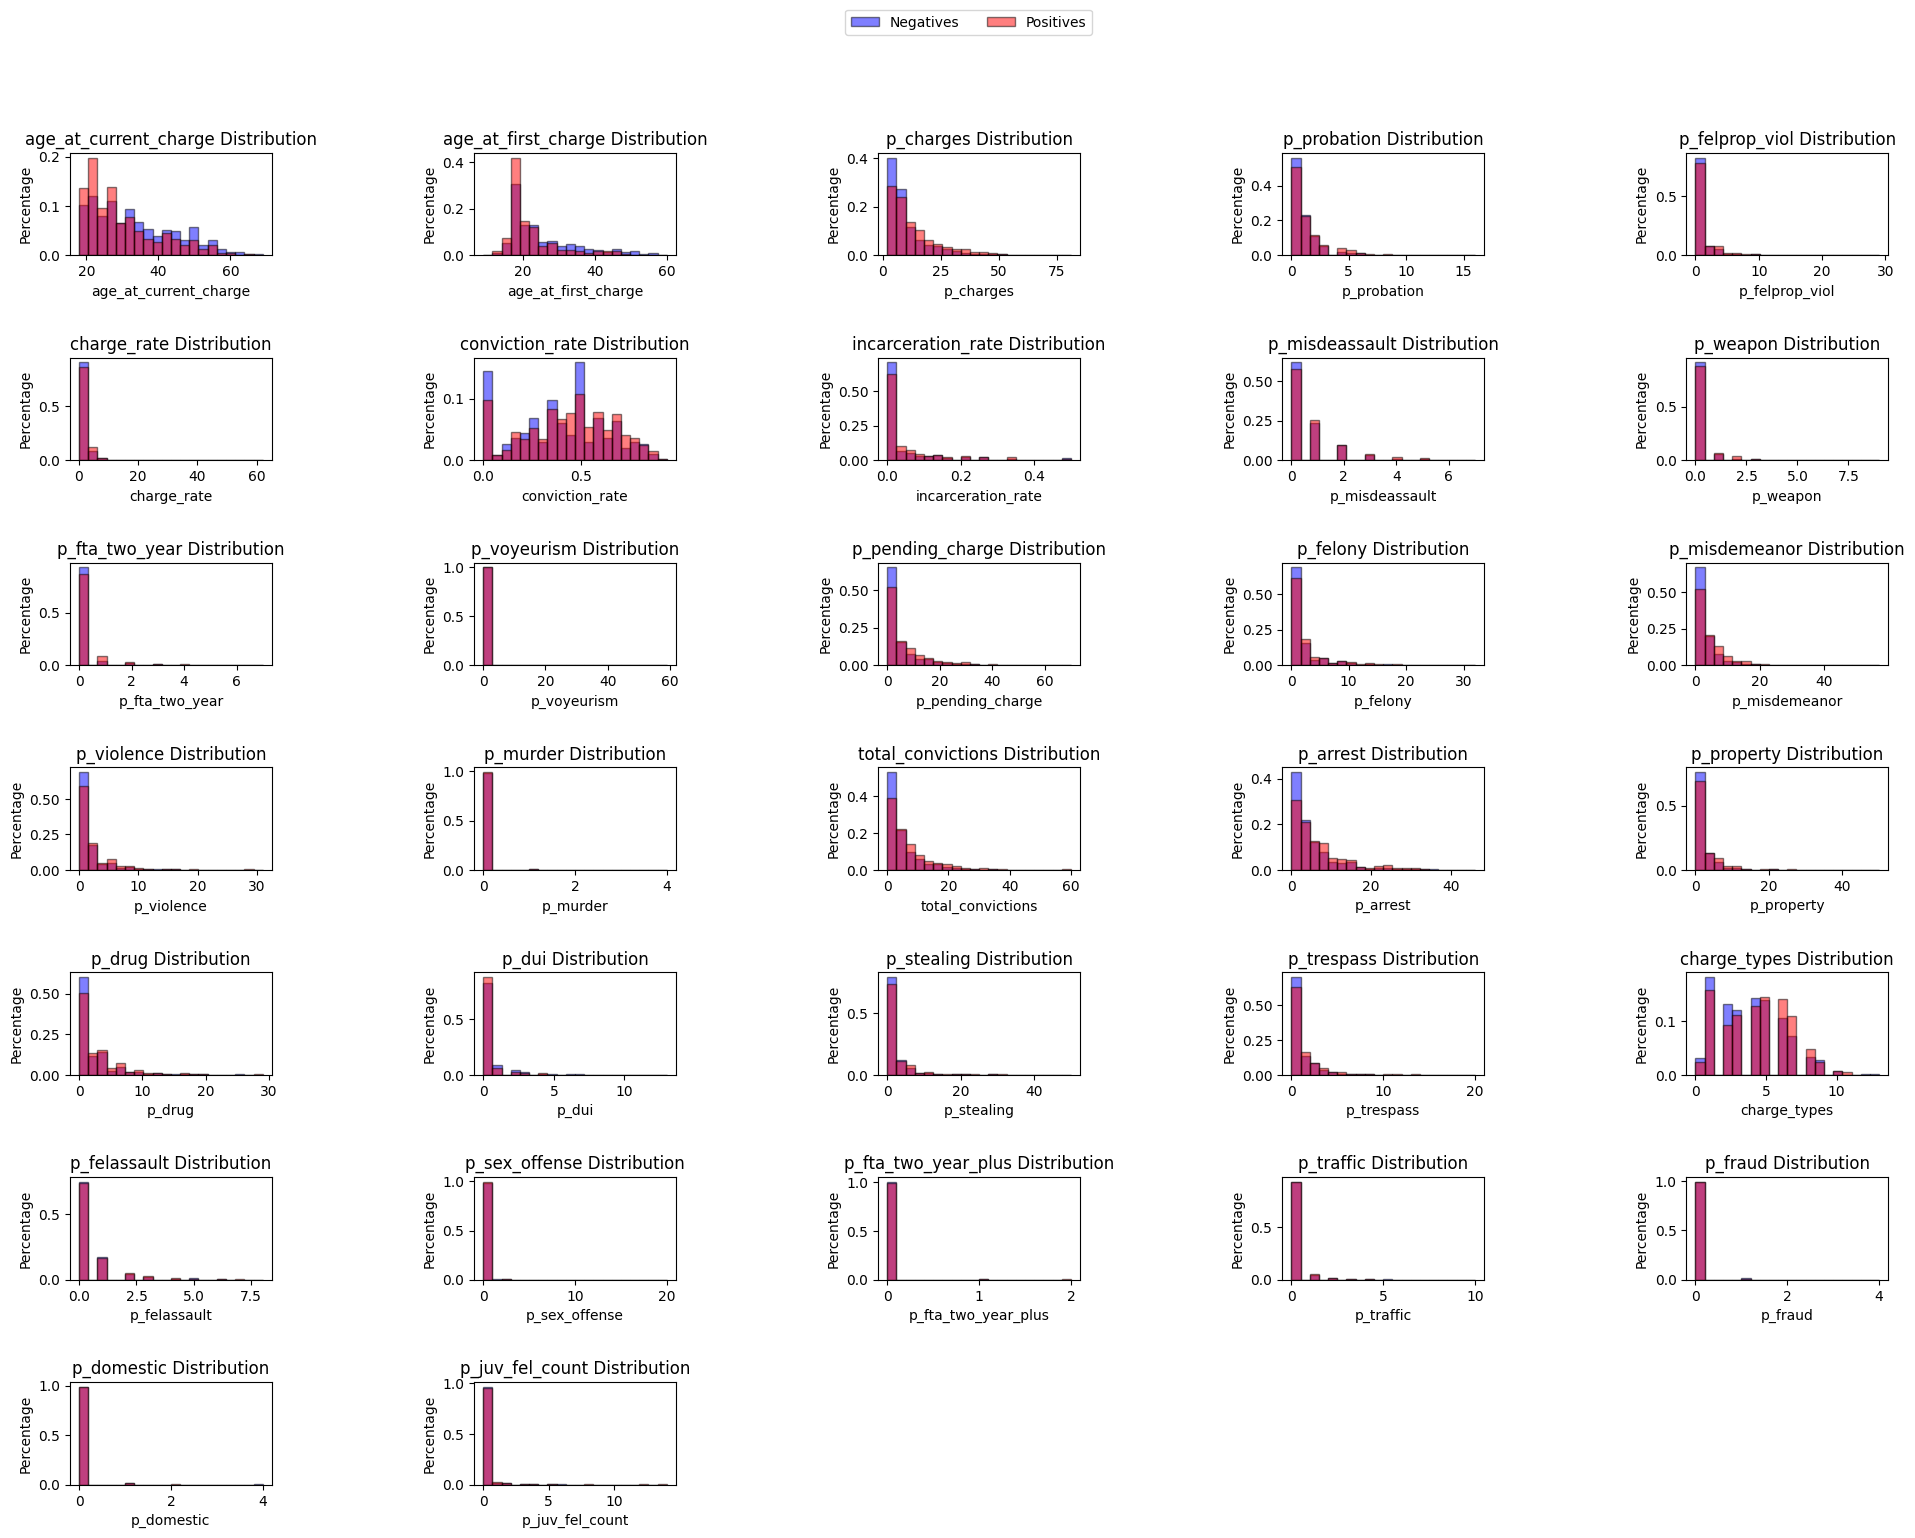

In [116]:
numerical = ['age_at_current_charge',
            'age_at_first_charge','p_charges','p_probation',
            'p_felprop_viol', 'charge_rate','conviction_rate','incarceration_rate',
            'p_misdeassault','p_weapon','p_fta_two_year','p_voyeurism',
            'p_pending_charge','p_felony','p_misdemeanor','p_violence','p_murder',
            'total_convictions','p_arrest','p_property','p_drug','p_dui',
            'p_stealing','p_trespass','charge_types','p_felassault',
            'p_sex_offense','p_fta_two_year_plus',
            'p_traffic', 
            'p_fraud','p_domestic','p_juv_fel_count'
            ]



cols = 5
rows = (len(numerical)+cols-1)//cols 

fig, axes = plt.subplots(rows, cols, figsize=(20,15))  # 
fig.tight_layout(pad=5.0)

for i, feature in enumerate(numerical):
    row = i // cols
    col = i % cols
    ax = axes[row, col]

    negatives = dataset[dataset['general_two_year'] == 0][feature]
    positives = dataset[dataset['general_two_year'] == 1][feature]

    weights_negatives = np.ones_like(negatives) / len(negatives)
    weights_positives = np.ones_like(positives) / len(positives)
    bins = np.linspace(min(dataset[feature]), max(dataset[feature]), 21)
    


    ax.hist(negatives, bins=bins, weights=weights_negatives, color='blue', alpha=0.5, label='Negatives', edgecolor='black')
    ax.hist(positives, bins=bins, weights=weights_positives, color='red', alpha=0.5, label='Positives', edgecolor='black')

    
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel(feature)
    ax.set_ylabel("Percentage")
    

for n in range(i+1, rows*cols):
    axes.flatten()[n].axis('off')

plt.subplots_adjust(hspace=1, wspace=1)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05))


plt.show()



## **Split into test and training**

In [117]:
X = dataset[features]   # feature values for all rows in cleaned dataset
y = dataset[targets]    # target values for all rows in cleaned dataset

### SPLIT INTO TRAIN AND TEST SETS ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [120]:
### .CSV FILES FOR TRAINING AND TESTING ###
X_train = pd.DataFrame(X_train, columns=features).reset_index(drop=True)
X_test = pd.DataFrame(X_test, columns=features).reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)
train_data.to_csv('cleaned_training.csv', index=False)
test_data.to_csv('cleaned_testing.csv', index=False)
